In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import scipy
import math

C:\Users\saiha\Documents\Hosted Experiments\NLPProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Datasets

we have loaded the datasets using the hugging face's datasets library, we have observed the TL-DR Datasets split already done into train, test and validation

In [2]:
data_set = load_dataset("trl-lib/tldr")
ds = data_set

In [3]:
train_set = pd.DataFrame(ds["train"])
print(ds.keys())

dict_keys(['train', 'validation', 'test'])


In [4]:
train_size, validation_size, test_size = ds["train"].shape[0], ds["validation"].shape[0], ds["test"].shape[0]
toto = train_size + validation_size + test_size

print("Training Set Size: ", "{:.2f}".format(train_size / toto * 1e2), "%",  " With Records: ", train_size,sep="")
print("Test Set Size: ", "{:.2f}".format(test_size / toto * 1e2), "%",  " With Records: ", test_size,sep="")
print("Validation Set Size: ", "{:.2f}".format(validation_size / toto * 1e2), "%", " With Records: ", validation_size, sep="")

Training Set Size: 89.98% With Records: 116722
Test Set Size: 5.05% With Records: 6553
Validation Set Size: 4.97% With Records: 6447


In [5]:
record = train_set.sample(random_state=56)

In [6]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

In [7]:
print(record.completion.values[0])

 Parking pass registered for 2 vehicles was left at home.  Appeal was denied, nobody has responded. Fee increases tomorrow.


## Task

* Extract Title
* Extract Post

## Extract Title - using Regex

In [8]:
print(record.prompt.str.extract(r'TITLE: ((.|\n)*)\n\nPOST:').values[0][0])

Is my school extorting me?


## Extract Post - using Regex

In [9]:
print(record.prompt.str.extract(r'POST: ((.|\n)*)\nTL;DR:', expand=False).values[0][0])

I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I can't afford to pay the extra $15.  If I don't pay the ticket at 

In [10]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

## Extracting the Title and the Post from the dataset into seperate columns.

Convert the Dataset to Data Frame and then add columns for post and title

In [11]:
ds = {}
for set_type in data_set.keys():
  ds[set_type] = pd.DataFrame(data_set[set_type])
  ds[set_type]["prompt_post"] = ds[set_type].prompt.str.extract(
      r'POST: ((.|\n)*)\nTL;DR:', expand=False
  ).iloc[:, 0]
  ds[set_type]["prompt_title"] = ds[set_type].prompt.str.extract(
    r'TITLE: ((.|\n)*)\n\nPOST:', expand=False
  ).iloc[:, 0]


In [12]:
train_set = ds["train"]
print(train_set.iloc[0, :])

prompt          SUBREDDIT: r/relationships\n\nTITLE: I (f/22) ...
completion       I still have contact with an old ex's friends...
prompt_post     Not sure if this belongs here but it's worth a...
prompt_title    I (f/22) have to figure out if I want to still...
Name: 0, dtype: object


# Do some basic statistics on the Train set

* Extract the Number of Words in the Prompt
* Extract the Number of Words in the Completion Text
* Extract the Number of Words in the Title


and see if there's any pattern between them

In [16]:
n_words_prompt = []
n_words_completion = []
n_words_title = []
for prompt, completion, title in zip(train_set.prompt, train_set.completion, train_set.prompt_title):
  n_words_prompt.append(len(prompt.split()))
  n_words_completion.append(len(completion.split()))
  n_words_title.append(len(title.split()))

counts = pd.DataFrame(
    {
        "prompt": n_words_prompt,
        "completion": n_words_completion,
        "title": n_words_title,
    }
)


In [17]:
for (task, _counts) in ((
    ("Prompt", n_words_prompt),
    ("Prompt's Completion", n_words_completion),
    ("Prompt's Title", n_words_title),
)):
    stats = scipy.stats.describe(_counts)
    print("Stats for the", task, ":", stats)
    print("STD:", math.sqrt(stats.variance))
    print()

Stats for the Prompt : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(11), np.int64(442)), mean=np.float64(266.40081561316634), variance=np.float64(6029.432066572026), skewness=np.float64(-0.06594287659561676), kurtosis=np.float64(-0.863107830526471))
STD: 77.64941768340589

Stats for the Prompt's Completion : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(7), np.int64(47)), mean=np.float64(27.02162402974589), variance=np.float64(34.70547220250788), skewness=np.float64(0.48083771190937125), kurtosis=np.float64(-0.4477978319286593))
STD: 5.891135052136208

Stats for the Prompt's Title : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(1), np.int64(64)), mean=np.float64(15.78543033875362), variance=np.float64(60.80944391184177), skewness=np.float64(0.9344021016085521), kurtosis=np.float64(1.56691256417108))
STD: 7.7980410304025565



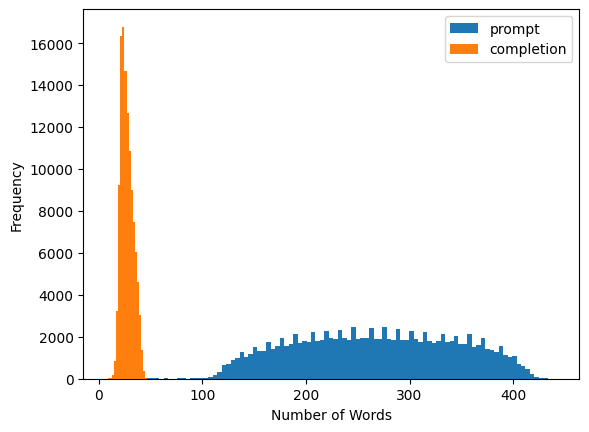

In [18]:
plt.hist(n_words_prompt, bins=100, label="prompt")
plt.hist(n_words_completion, bins = 20, label = "completion")
plt.ylabel("Frequency")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

## Scatter Matrix between prompt, completion and title

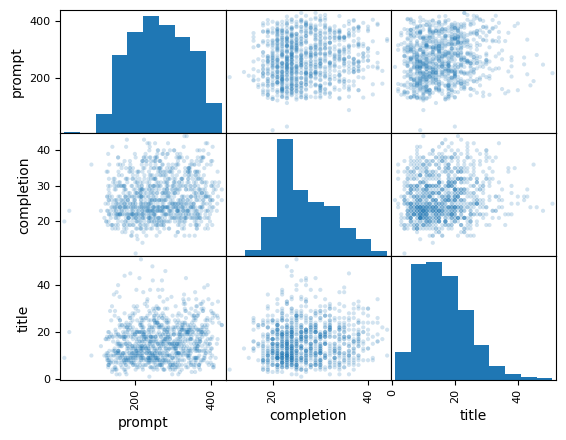

In [19]:
_ = pd.plotting.scatter_matrix(counts.sample(1000), alpha=0.2)

In [20]:
# correlation?
print(scipy.stats.linregress(n_words_prompt, n_words_completion))
print()
print(scipy.stats.linregress(n_words_prompt, n_words_title))
print()
print(scipy.stats.linregress(n_words_title, n_words_completion))

LinregressResult(slope=np.float64(0.009730547772109977), intercept=np.float64(24.429398166892913), rvalue=np.float64(0.12825565218894822), pvalue=np.float64(0.0), stderr=np.float64(0.00022023506420592166), intercept_stderr=np.float64(0.06111226400406934))

LinregressResult(slope=np.float64(0.01007863606800162), intercept=np.float64(13.100473469969714), rvalue=np.float64(0.1003585668082715), pvalue=np.float64(6.267295155289465e-259), stderr=np.float64(0.00029246675883452247), intercept_stderr=np.float64(0.08115558638563623))

LinregressResult(slope=np.float64(0.07443448768270902), intercept=np.float64(25.846643609629673), rvalue=np.float64(0.09852824352011456), pvalue=np.float64(1.3293605950284917e-249), stderr=np.float64(0.0022005057079933455), intercept_stderr=np.float64(0.038743196977776354))


## Conclusions till now

1. Longer Post had longer TLDR's but the change is less as `p-value` is .12
2. Practically, post length or title length does not strongly predict TLDR length.


# Evaluting the Quality of the TL;Dr

we are now seeing the quality of the completion text (tldr) generated from the reddit posts first using the content Overlap metrics.

we would be using the Test Dataset for now as there are many records in the training dataset.

In [13]:
from rouge_score import rouge_scorer
import plotly.express as px

In [14]:
test_set = ds["test"].sample(1000)
test_set.columns, test_set.shape

(Index(['prompt', 'completion', 'prompt_post', 'prompt_title'], dtype='object'),
 (1000, 4))

In [15]:
record = test_set.sample(random_state=56)
print(record.prompt.values[0])
print("-------------------------------")
print(record.completion.values[0])

SUBREDDIT: r/relationships

TITLE: I can't even bare the sight my employee, need advice on how to deal with this

POST: I manage a team of people and one of my team members is a girl who is about the same age as me, but she is incredibly quiet, but can give you attitude if point out something that she's done incorrectly. Her English isn't great, which wouldn't be a problem except for that she'll say she understands something and then not do what you've asked for. She's just generally a bit useless. 

She's a hard worker, but she has the memory of a goldfish, needs constant oversight of her work for mistakes, has minimal common sense, and is completely lacking in creativity and insight.

The biggest issue though is that she creeps me out. She's always staring, but doesn't say much. I can't stand how useless she is considering she's about to turn 30. She makes my work life more difficult than it needs to be because everything she does has to be checked over.

It's gotten to the point whe

In [16]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scorer.score(record.prompt.values[0], record.completion.values[0])

{'rouge1': Score(precision=0.8571428571428571, recall=0.1037463976945245, fmeasure=0.18508997429305912),
 'rougeL': Score(precision=0.6428571428571429, recall=0.07780979827089338, fmeasure=0.13881748071979436)}

In [17]:
scores_df = test_set[["prompt", "completion"]].apply(
    lambda x: pd.Series({
        'rouge1_precision': scorer.score(x.iloc[0], x.iloc[1])['rouge1'].precision,
        'rouge1_recall': scorer.score(x.iloc[0], x.iloc[1])['rouge1'].recall,
        'rouge1_fmeasure': scorer.score(x.iloc[0], x.iloc[1])['rouge1'].fmeasure,
        'rougeL_precision': scorer.score(x.iloc[0], x.iloc[1])['rougeL'].precision,
        'rougeL_recall': scorer.score(x.iloc[0], x.iloc[1])['rougeL'].recall,
        'rougeL_fmeasure': scorer.score(x.iloc[0], x.iloc[1])['rougeL'].fmeasure,
    }),
    axis=1
)

In [18]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=scores_df["rouge1_precision"],
    name="ROUGE-1 Precision",
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=scores_df["rouge1_recall"],
    name="ROUGE-1 Recall",
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=scores_df["rouge1_fmeasure"],
    name="ROUGE-1 F-measure",
    histnorm='probability',
    opacity=0.75
))

fig.update_layout(
    barmode='overlay',
    title='ROUGE-1 Score Distributions',
    xaxis_title='Score',
    yaxis_title='Probability',
    template='plotly_dark'
)

fig.show()


## ROUGE-1 F1 Score Formula
---
ROUGE-1 measures unigram overlap between a candidate and reference text.

$$
\text{ROUGE-1}_{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Where:

$$
\text{Precision} = \frac{\text{Overlapping Unigrams}}{\text{Total Unigrams in Candidate}}
$$

$$
\text{Recall} = \frac{\text{Overlapping Unigrams}}{\text{Total Unigrams in Reference}}
$$

## Conclusion based on the Rouge Unigram Score's Precision
---

I believe we can expect the recall and f measures to be less value for the summarizer as the TL;DR is supposed to have the compressed words from the prompt.

but interestly...
we can see mostly ~80% of the words in the tl;dr are also present in the prompt.

That is the TL;DR is mostly extractive, but includes some words (~20%) words which were not from the prompt.

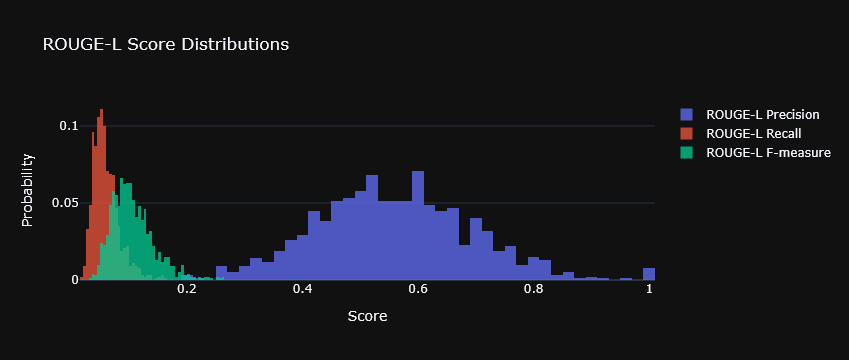

In [19]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=scores_df["rougeL_precision"],
    name="ROUGE-L Precision",
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=scores_df["rougeL_recall"],
    name="ROUGE-L Recall",
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=scores_df["rougeL_fmeasure"],
    name="ROUGE-L F-measure",
    histnorm='probability',
    opacity=0.75
))

fig.update_layout(
    barmode='overlay',
    title='ROUGE-L Score Distributions',
    xaxis_title='Score',
    yaxis_title='Probability',
    template='plotly_dark'
)

fig.show()


## ROUGE-L F1 Score Formula
---
ROUGE-L measures the longest common subsequence (LCS) between a candidate and reference text.

$$
\text{ROUGE-L}_{F1} = \frac{(1 + \beta^2) \cdot \text{Precision} \cdot \text{Recall}}{\text{Recall} + \beta^2 \cdot \text{Precision}}
$$

Where typically \( \beta = \frac{\text{Recall}}{\text{Precision}} \), so F1 balances both.

Definitions:

$$
\text{Precision} = \frac{\text{LCS}(X, Y)}{\text{Length of Candidate}}
$$

$$
\text{Recall} = \frac{\text{LCS}(X, Y)}{\text{Length of Reference}}
$$

Here, $\text{LCS}(X, Y)$ is the length of the longest common subsequence between the reference $X$ and the candidate $Y$.

## Conclusion based on the RougeL_Precision
---

though the TL;DR seems to have most of the words coming from the prompt but it does not seem to be copying specific part of the sequence of the prompt only (which is expected from good sumarizer) so it is generating TL;DR of the post though it uses most of the words from the prompt but the ordering and paraphrasing is not copied exactly.


# Evaluting with Model based Metrics

we are now seeing how does the completion makes sense semantically.

In [20]:
print(record.completion.values[0])  # we are going to check if the value here makes sense

 I can't stand my useless employee, and it's gotten to the point where I don't even want to look at her or her name. How can I deal with my feelings, so I can work harmoniously with this person?
